In [11]:
import h5py

f_rainnet = h5py.File('/data/softec-lagrangian-nowcasting/outputs/RainNet/RainNet-iterative.h5', 'r')
f_lcnn = h5py.File('/data/softec-lagrangian-nowcasting/outputs/lagrangian/lcnn-bugfix_v2/lcnn-bugfix.h5', 'r')
f_lupin = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-ECAI/LUPIN-ECAI.h5', 'r')

In [12]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_differenced"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

In [13]:
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
import numpy as np

plt.rcParams["font.family"] = "monospace"

sample_idx = random.randrange(len(dataset))
sample_idx = 40
sample_key = dataset.get_common_time(sample_idx).strftime("%Y-%m-%d %H:%M:%S")

x, y, idx = dataset[sample_idx]
arr = np.zeros((6, 336, 336))
y_arr = np.zeros((6, 336, 336))

f = f_rainnet
for i in range(0, 6):
    arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
    arr[i][arr[i] < 64] = 64
    arr[i] = arr[i] / 2 - 32
arr_rainnet = arr.copy()

f = f_lcnn
for i in range(0, 6):
    arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
    arr[i][arr[i] < 64] = 64
    arr[i] = arr[i] / 2 - 32
arr_lcnn = arr.copy()

f = f_lupin
for i in range(0, 6):
    arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
    arr[i][arr[i] < 64] = 64
    arr[i] = arr[i] / 2 - 32
arr_lupin = arr.copy()

for i in range(0, 6):
    y_arr[i] = np.array(dataset.from_transformed(y[i][0]))

def dbztommh(data):
    data = 10 ** (data * 0.1)
    data = (data / 200) ** (1 / 1.6)
    data[data < 1] = 0
    return data

/tmp/ipykernel_3619606/3282982578.py:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
/tmp/ipykernel_3619606/3282982578.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
/tmp/ipykernel_3619606/3282982578.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])


In [14]:
from pysteps.visualization import plot_precip_field

def plottoax(map, ax, title):
    plot_precip_field(dbztommh(map), colorbar=False, units='mm/h', ax=ax)
    # axes[0].axis('off')
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True, alpha=0.5)

    x1, x2, y1, y2 = 3*42, 4*42, 4.5*42, 5.5*42  # subregion of the original image
    axins = ax.inset_axes(
        [0.025, 0.025, 0.375, 0.375],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    plot_precip_field(dbztommh(map), colorbar=False, units='mm/h', ax=axins)
    ax.indicate_inset_zoom(axins, edgecolor="black")
    
    ax.set_title(title)

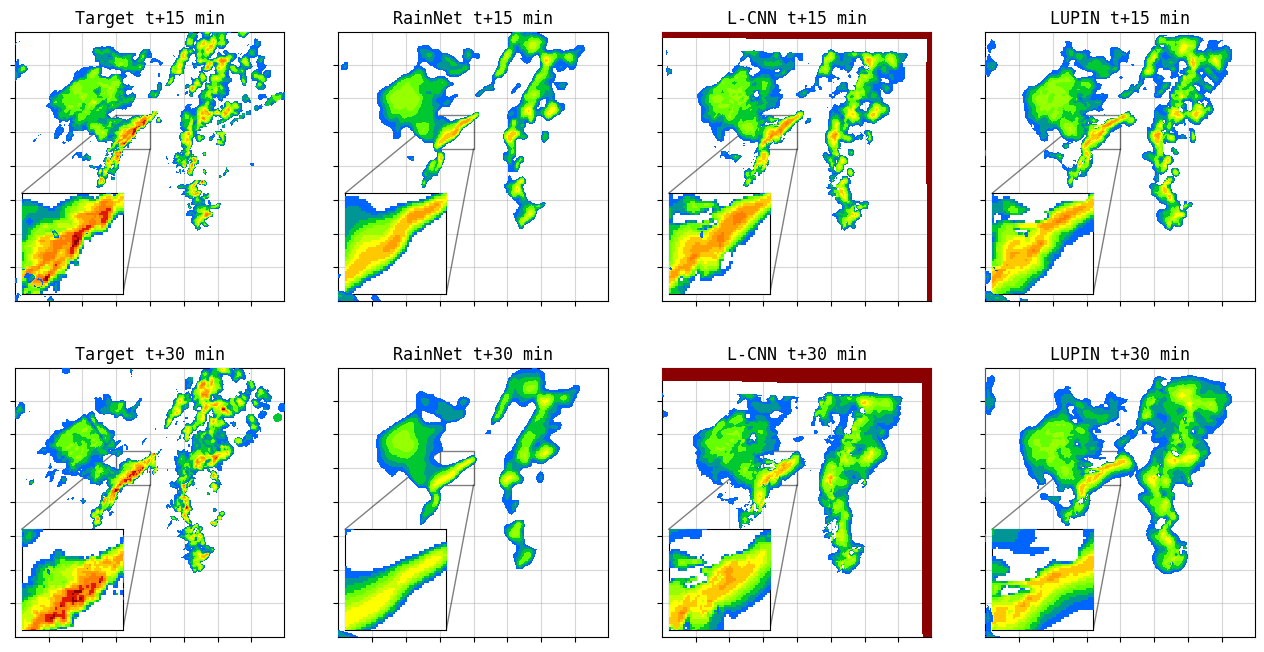

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))

plottoax(y_arr[2], axes[0][0], 'Target t+15 min')
plottoax((arr_rainnet[2]), axes[0][1], 'RainNet t+15 min')
plottoax(arr_lcnn[2], axes[0][2], 'L-CNN t+15 min')
plottoax(arr_lupin[2], axes[0][3], 'LUPIN t+15 min')

plottoax(y_arr[-1], axes[1][0], 'Target t+30 min')
plottoax((arr_rainnet[-1]), axes[1][1], 'RainNet t+30 min')
plottoax(arr_lcnn[-1], axes[1][2], 'L-CNN t+30 min')
plottoax(arr_lupin[-1], axes[1][3], 'LUPIN t+30 min')

plt.savefig("compare.pdf", bbox_inches='tight')

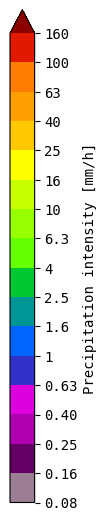

In [80]:
fig, axes = plt.subplots(1, 1, figsize=(16,8))
plot_precip_field(dbztommh(y_arr[-1]), colorbar=True, units='mm/h')
plt.gca().set_visible(False)
plt.savefig("cbar.pdf", bbox_inches='tight')